In [1]:
import pandas as pd
import torch


### For Reproducibility

In [2]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disables fast auto-tuning

# Set seed for reproducibility
set_seed(42)


In [3]:
%%time

df1 = pd.read_pickle('data/methyl_scores_v1_HM450k_1.pkl', compression="bz2")
df2 = pd.read_pickle('data/methyl_scores_v1_HM450k_2.pkl', compression="bz2")
df3 = pd.read_pickle('data/methyl_scores_v1_HM450k_3.pkl', compression="bz2")
df4 = pd.read_pickle('data/methyl_scores_v1_HM450k_4.pkl', compression="bz2")
df5 = pd.read_pickle('data/methyl_scores_v1_HM450k_5.pkl', compression="bz2")
df = pd.concat([df1, df2, df3, df4, df5], axis=0)
# df = pd.read_pickle('data/methyl_scores_v1_HM450k_1.pkl', compression="bz2")



CPU times: user 9min 22s, sys: 5.48 s, total: 9min 27s
Wall time: 9min 29s


In [4]:
df.shape

(11694, 485590)

In [5]:
df[['id', 'geo_accession', 'title', 'sex', 'age', 'race', 'disease',
       'tissue', 'geo_platform', 'inferred_sex', 'inferred_age_Hannum',
       'inferred_age_SkinBlood', 'inferred_age_Horvath353']]

,id,geo_accession,title,sex,age,race,disease,tissue,geo_platform,inferred_sex,inferred_age_Hannum,inferred_age_SkinBlood,inferred_age_Horvath353
GSM3944747,103392,GSM3944747,"AD, CBL sample 03--34",female,88,None,Alzheimer's disease,brain,GPL13534,F,34.520802,9.871158,65.031621
GSM3944748,103393,GSM3944748,"AD, CBL sample 08--45",male,78,None,Alzheimer's disease,brain,GPL13534,M,30.496641,8.858558,60.821105
GSM3944749,103394,GSM3944749,"AD, CBL sample 08--59",male,89,None,Alzheimer's disease,brain,GPL13534,M,37.546386,11.725778,63.846017
GSM3944750,103395,GSM3944750,"AD, CBL sample 08--01",male,90,None,Alzheimer's disease,brain,GPL13534,M,31.407073,11.791566,59.617576
GSM3944751,103396,GSM3944751,"AD, CBL sample 01--45",female,87,None,Alzheimer's disease,brain,GPL13534,F,30.523229,13.329728,65.524861
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM4317289,114835,GSM4317289,200078650258_R01C02,male,None,None,control,blood,GPL13534,M,69.873144,70.297545,71.124282
GSM4317290,114836,GSM4317290,200078650258_R03C02,female,None,None,control,blood,GPL13534,F,75.717975,74.210118,77.139598
GSM4317291,114837,GSM4317291,200078650258_R04C02,male,None,None,Parkinson's disease,blood,GPL13534,M,73.383265,67.509537,70.919180
GSM4317292,114838,GSM4317292,200078650258_R05C02,female,None,None,control,blood,GPL13534,F,76.227048,72.524829,72.624740


# Prepare the data

In [6]:
# Assuming `df` is your DataFrame
metadata_columns = ['id', 'geo_accession', 'title', 'sex', 'age', 'race',
                    'tissue', 'geo_platform', 'inferred_age_Hannum',
                    'inferred_age_SkinBlood', 'inferred_age_Horvath353']  # list of metadata columns

label_column = 'disease'  # column with target values for classification/regression
condition_column = 'inferred_sex'
numerical_data = df.drop(metadata_columns + [label_column] + [condition_column], axis=1)  # features for training



Fill in the NA values in the `label_column`

In [7]:
default_value = 'no_label'
df[label_column].fillna(default_value, inplace=True)

labels = df[label_column]  # target/label for model training
conditions = df[condition_column]  # target/label for model training

/tmp/7389856.1.gpu.q/ipykernel_2683849/744962163.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[label_column].fillna(default_value, inplace=True)


In [8]:
labels.value_counts()

disease
control                                  5380
no_label                                 1471
Alzheimer's disease                      1204
Parkinson's disease                       959
rheumatoid arthritis                      718
osteoporosis                              264
multiple sclerosis                        240
Crohn's disease                           177
diabetes mellitus                         143
gestational diabetes                      122
Creutzfeldt-Jakob disease                 114
fetal alcohol spectrum disorder           112
mild cognitive impairment                 111
hepatocellular carcinoma                  105
ulcerative colitis                         87
glioblastoma                               72
pre-eclampsia                              71
type 2 diabetes mellitus                   65
lupus erythematosus                        57
chronic obstructive pulmonary disease      50
major depressive disorder                  40
substance-related disorder

## Detect and drop unreliable columns

In [9]:
# numerical_data.isna().sum(axis=0)

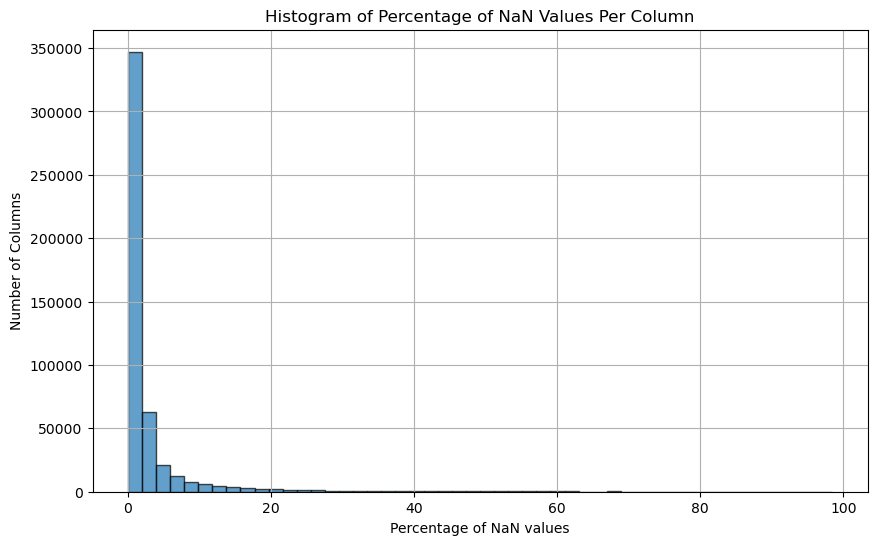

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# # Calculate the percentage of NaN values in each column
nan_percentage = numerical_data.isna().sum(axis=0) / numerical_data.shape[0] * 100

# Plot the histogram of the percentage of NaN values per column
plt.figure(figsize=(10, 6))
plt.hist(nan_percentage, bins=50, edgecolor='k', alpha=0.7)
plt.title("Histogram of Percentage of NaN Values Per Column")
plt.xlabel("Percentage of NaN values")  
plt.ylabel("Number of Columns")
plt.grid(True)

plt.show()


In [11]:
print(f"more than 1% NaN: {(nan_percentage>1).sum()}")
print(f"more than 5% NaN: {(nan_percentage>5).sum()}")
print(f"more than 10% NaN: {(nan_percentage>10).sum()}")
print(f"more than 15% NaN: {(nan_percentage>15).sum()}")
print(f"more than 20% NaN: {(nan_percentage>20).sum()}")
print(f"more than 30% NaN: {(nan_percentage>30).sum()}")


more than 1% NaN: 192121
more than 5% NaN: 62648
more than 10% NaN: 33830
more than 15% NaN: 21686
more than 20% NaN: 15110
more than 30% NaN: 8532


In [20]:
# Select subset of columns where NaN percentage is less than 10%
selected_columns = nan_percentage[nan_percentage < 10].index.tolist()

# Create a new DataFrame with the selected columns
numerical_data_filtered = numerical_data[selected_columns]



In [21]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)

# Convert categorical labels to one-hot vectors
labels_onehot = onehot_encoder.fit_transform(labels.values.reshape(-1, 1))



In [22]:
labels_onehot.shape

(11694, 27)

In [23]:
# %%time
# from sklearn.preprocessing import StandardScaler

# SCALE = True
# ## With SCALE = False, the loss would explode! therefore, we scale the data to control the range of the loss and the gradients
# if SCALE:
#     scaler = StandardScaler()
#     features_scaled = scaler.fit_transform(numerical_data_filtered)
# else:
#     features_scaled = numerical_data_filtered.values

In [24]:
### Todo Should separate scaling for train, validation, and test: like the following
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)  # Fit only on train data
# X_val_scaled = scaler.transform(X_val)  # Apply the same scaler to validation and test data
# X_test_scaled = scaler.transform(X_test)



In [25]:
labels_onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
%%time
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.preprocessing import StandardScaler

# Start by assuming your data is unscaled
numerical_data_filtered = numerical_data_filtered.values  # Assuming this is your data
labels_onehot = labels_onehot  # Assuming these are your labels

# Convert one-hot encoded labels to class indices
labels_class = np.argmax(labels_onehot, axis=1)  # Convert one-hot to class labels

# Stratified shuffle split (30% test set, 70% train) based on class indices
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in splitter.split(numerical_data_filtered, labels_class):
    X_train, X_temp = numerical_data_filtered[train_index], numerical_data_filtered[test_index]
    y_train, y_temp = labels_onehot[train_index], labels_onehot[test_index]  # Use one-hot labels for actual training

# Split the temp set into validation and test sets (15% val, 15% test)
splitter_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_index, test_index in splitter_val_test.split(X_temp, np.argmax(y_temp, axis=1)):  # Use class labels here
    X_val, X_test = X_temp[val_index], X_temp[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]


CPU times: user 4min 38s, sys: 28.4 s, total: 5min 6s
Wall time: 5min 7s


In [ ]:
# Now scale the data
SCALE = True
if SCALE:
    scaler = StandardScaler()

    # Fit the scaler only on the training data
    X_train_scaled = scaler.fit_transform(X_train)

    # Apply the same scaler to the validation and test sets
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
else:
    # If scaling is turned off, use the raw data
    X_train_scaled = X_train
    X_val_scaled = X_val
    X_test_scaled = X_test
    

In [27]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))

# Check the stratified split
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (8185, 451747)
Validation set size: (1754, 451747)
Test set size: (1755, 451747)


# Build VAE

In [28]:
import os

# Set the environment variable inside the script
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F


In [29]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims=[2048,1024,512], dropout_rate=0.2):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder_layers = self.build_layers(input_dim, hidden_dims, dropout_rate)
        # self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)  # for mean
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)  # for log variance
        
        # Decoder
        decoder_hidden_dims = hidden_dims[::-1]
        self.decoder_layers =self.build_layers(latent_dim, decoder_hidden_dims, dropout_rate)
        self.fc_output = nn.Linear(hidden_dims[0], input_dim)
        # self.fc3 = nn.Linear(latent_dim, hidden_dim)
        # self.fc4 = nn.Linear(hidden_dim, input_dim)

    def build_layers(self, input_dim, hidden_dims, dropout_rate):
        layers = []
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = h_dim
        return nn.Sequential(*layers)
    
    def encode(self, x):
        h = self.encoder_layers(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        # Check if logvar has NaN or Inf values
        if torch.isnan(logvar).any() or torch.isinf(logvar).any():
            print(f"NaN or Inf detected in logvar: logvar={logvar}")
        
        # Clamp logvar to prevent extreme values
        logvar = torch.clamp(logvar, min=-10, max=10)
        
        # Calculate std from logvar
        std = torch.exp(0.5 * logvar)
        
        # Check if std has NaN or Inf values
        if torch.isnan(std).any() or torch.isinf(std).any():
            print(f"NaN or Inf detected in std computation: std={std}")
        
        # Sample from the latent space
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        # Check if z has NaN or Inf values
        if torch.isnan(z).any() or torch.isinf(z).any():
            print(f"NaN or Inf detected in z computation: z={z}")
        
        return z

    def decode(self, z):
        h = self.decoder_layers(z)
        # h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc_output(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def get_latent_embedding(self, x):
        """
        Method to get the latent embedding (the `z` vector) for an input.
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)  # this is the embedding
        return z


In [30]:
class VAE_Lightning(pl.LightningModule):
    def __init__(self, input_dim=485577, latent_dim=128, hidden_dims=[2048, 1024, 512], dropout_rate=0.2, lr=1e-6):
        super(VAE_Lightning, self).__init__()
        
        self.save_hyperparameters()  # Save hyperparameters for checkpointing

        self.model = VAE(input_dim, latent_dim, hidden_dims, dropout_rate)
        self.lr = lr
    
    def forward(self, x):
        mu, logvar = self.model.encode(x)
        z = self.model.reparameterize(mu, logvar)
        return z, mu, logvar

    def get_latent_embedding(self, x):
        return self.model.get_latent_embedding(x)
        
    def training_step(self, batch, batch_idx):
        x, _ = batch

        # Step 1: Create mask before replacing NaN values
        mask = ~torch.isnan(x)  # mask where values are not NaN

        # Step 2: Replace NaNs with zero or another neutral value for forward pass
        x_filled = replace_nan_with_mean(x)
        # x_filled = torch.nan_to_num(x, nan=0.0)

        # Step 3: Pass through the model with filled values
        z, mu, logvar = self.forward(x_filled)
        x_hat, _, _ = self.model(x_filled)

        # Step 4: Use the original x (with NaNs) and mask to calculate the loss
        loss = self._vae_loss(x, x_hat, mu, logvar, mask)
        print(f"Training loss: {loss.item()}")

        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    
    def validation_step(self, batch, batch_idx):
        x, _ = batch

        # Step 1: Create mask before replacing NaN values
        mask = ~torch.isnan(x)

        # Step 2: Replace NaNs with zero or another neutral value for forward pass
        x_filled = replace_nan_with_mean(x)
        # x_filled = torch.nan_to_num(x, nan=0.0)

        # Step 3: Pass through the model with filled values
        z, mu, logvar = self.forward(x_filled)
        x_hat, _, _ = self.model(x_filled)

        # Step 4: Use the original x (with NaNs) and mask to calculate the loss
        loss = self._vae_loss(x, x_hat, mu, logvar, mask)
        print(f"Validation loss: {loss.item()}")

        self.log('val_loss', loss, on_step=False, on_epoch=True)
  

    def _vae_loss(self, original_x, x_hat, mu, logvar, mask):
        # Apply mask to ignore NaN values in the loss calculation
        recon_loss = F.mse_loss(x_hat[mask], original_x[mask], reduction='mean')
    
        # Scale the KL divergence to balance the losses
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_loss = kl_loss / original_x.shape[0]  # Normalize by batch size or apply weighting
    
        return recon_loss + kl_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [31]:
from pytorch_lightning.callbacks import Callback

class LossHistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the loss for the last training epoch from the logs
        train_loss = trainer.callback_metrics.get('train_loss')
        if train_loss is not None:
            self.train_losses.append(train_loss.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Access the loss for the last validation epoch from the logs
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None:
            self.val_losses.append(val_loss.item())



def replace_nan_with_mean(x):
    # Calculate the column-wise mean, ignoring NaNs
    col_mean = torch.nanmean(x, dim=0)
    
    # Find where NaN values are located
    nan_mask = torch.isnan(x)
    
    # Replace NaNs with the corresponding column means
    x[nan_mask] = torch.take(col_mean, nan_mask.nonzero()[:, 1])
    
    # Check if there are still NaN or Inf values
    if torch.isnan(x).any() or torch.isinf(x).any():
        print("NaN or Inf detected in the input data after imputation!")
    
    return x

## Train VAE

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
%%time
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer, loggers

# Create a logger
logger = loggers.CSVLogger('lightning_logs/', name='m1_vae')


pl.seed_everything(42)

# Initialize the VAE Lightning model
input_dim = X_train_tensor.shape[1]  # The number of input features
latent_dim = 256  # Latent dimension size, can be tuned
hidden_dims = [2048, 1024, 512]
dropout_rate = 0.2
lr = 1e-6

model = VAE_Lightning(
    input_dim=input_dim,
    latent_dim=latent_dim,
    hidden_dims=hidden_dims,
    dropout_rate=dropout_rate,
    lr=lr)

# Training
loss_history_callback = LossHistoryCallback()
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    dirpath=f'{logger.save_dir}/{logger.name}/version_{logger.version}/checkpoints/',
    filename='m1-vae-{epoch:02d}-{val_loss:.2f}'
    )

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

trainer = pl.Trainer(
    max_epochs=200,
    gradient_clip_val=0.5,  # Clip gradients to avoid explosion
    callbacks=[checkpoint_callback, early_stopping_callback, loss_history_callback],
    precision=32,
    accelerator='gpu',          # Use 'gpu' or 'cpu'
    devices=1 if torch.cuda.is_available() else 'auto',  # Use 1 GPU or CPU ('auto' will pick the appropriate one)
    deterministic=True,  # Ensure reproducibility
    logger=logger
)
trainer.fit(model, train_loader, val_loader)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | VAE  | 1.9 B  | train
---------------------------------------
1.9 B     Trainable params
0         Non-trainable params
1.9 B     Total params
7,425.805 Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 512/512 [03:20<00:00,  2.56it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/110 [00:00<?, ?it/s]Validation loss: 1.451522707939148

Validation DataLoader 0:   1%|          | 1/110 [00:00<00:03, 29.46it/s]Validation loss: 1.0252137184143066

Validation DataLoader 0:   2%|▏         | 2/110 [00:00<00:04, 25.12it/s]Validation loss: 1.5632591247558594

Validation DataLoader 0:   3%|▎         | 3/110 [00:00<00:04, 24.05it/s]Validation loss: 1.3815284967422485

Validation DataLoader 0:   4%|▎         | 4/110 [00:00<00:04, 23.55it/s]Validation loss: 1.0560461282730103

Validation DataLoader 0:   5%|▍         | 5/110 [00:00<00:04, 22.76it/s]Validation loss: 1.4290745258331299

Validation DataLoader 0:   5%|▌         | 6/110 [00:00<00:04, 22.61it/s]Validation loss: 1.141378402709961

Validation DataLoader 0:   6%|▋         | 7/110 [00:00<00:04, 22.64it/s]Validation loss: 1.3507944345474243

Validation DataLoader 0:

In [56]:
import yaml

# Load the hyperparameters from the hparams.yaml file
hparams_path = 'lightning_logs/version_3/hparams.yaml'  # Replace with the correct path
with open(hparams_path) as file:
    hparams = yaml.safe_load(file)

print(hparams)  # To inspect the hyperparameters


{'dropout_rate': 0.2, 'hidden_dims': [2048, 1024, 512], 'input_dim': 451747, 'latent_dim': 256, 'lr': 1e-06}


In [57]:
from pytorch_lightning import Trainer

# checkpoint_path = "lightning_logs/version_11/checkpoints/epoch=9-step=5120.ckpt"
checkpoint_path = "lightning_logs/version_1/checkpoints/epoch=24-step=12800.ckpt"

# input_dim = X_train_tensor.shape[1]  # The number of input features
# latent_dim = 128  # Latent dimension size, can be tuned
# hidden_dims = [2048, 1024, 512]
# dropout_rate = 0.2
# # hidden_dims = [1000]
# # dropout_rate = 0.0
# lr = 1e-6

loaded_model = VAE_Lightning.load_from_checkpoint(
    checkpoint_path,
    map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    **hparams
    )

loaded_model.eval()

VAE_Lightning(
  (model): VAE(
    (encoder_layers): Sequential(
      (0): Linear(in_features=451747, out_features=2048, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=1024, out_features=512, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.2, inplace=False)
    )
    (fc_mu): Linear(in_features=512, out_features=256, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=256, bias=True)
    (decoder_layers): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=1024, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=1024, out_features=2048, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.2, inplace=False)
    )
    (

In [ ]:
def get_latent_embeddings(model, dataloader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            x,y = batch

            x = x.to(device)
            y = y.to(device)
            
            # Replace NaNs with zero or another neutral value for forward pass
            x_filled = replace_nan_with_mean(x)
            # x_filled = torch.nan_to_num(x, nan=0.0)
            
            z, _, _ = model.forward(x_filled)
            embeddings.append(z)
            labels.append(y)
        
        embeddings = torch.cat(embeddings, dim=0)
        labels = torch.cat(labels, dim=0)

    return embeddings, labels

train_embeddings, train_labels = get_latent_embeddings(model, train_loader)
val_embeddings, val_labels = get_latent_embeddings(model, val_loader)
test_embeddings, test_labels = get_latent_embeddings(model, test_loader)

        

In [ ]:
train_embeddings.shape

In [ ]:
# import umap
# import matplotlib.pyplot as plt
# import numpy as np

# # Combine train and validation embeddings
# combined_embeddings = torch.cat([train_embeddings, val_embeddings], dim=0).cpu().numpy()
# combined_labels = torch.cat([train_labels, val_labels], dim=0).cpu().numpy()
# # Convert one-hot encoded labels to class indices using argmax
# combined_labels_1d = combined_labels.argmax(axis=1)  # Find the index of the maximum (1) in each one-hot vector

# # Fit UMAP on the combined embeddings
# umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
# combined_umap = umap_model.fit_transform(combined_embeddings)

# # Plot UMAP embeddings (train + validation)
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(combined_umap[:, 0], combined_umap[:, 1], c=combined_labels_1d, cmap='Spectral', s=10, alpha=0.8)
# plt.colorbar(scatter)
# plt.title('UMAP Projection of Train + Validation Embeddings')
# plt.show()


In [ ]:
# # Convert test one-hot encoded labels to class indices
# test_labels_1d = test_labels.cpu().numpy().argmax(axis=1)

# torch.cat([train_embeddings, val_embeddings], dim=0).cpu().numpy()

# # Project test embeddings onto the UMAP space
# test_umap = umap_model.transform(test_embeddings.cpu().numpy())

# # Plot the test UMAP embeddings
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(test_umap[:, 0], test_umap[:, 1], c=test_labels_1d, cmap='Spectral', s=10, alpha=0.8)
# plt.colorbar(scatter)
# plt.title('UMAP Projection of Test Embeddings')
# plt.show()


# MLP building

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import Adam

class MLP(pl.LightningModule):
    def __init__(self, input_dim, layer_dims, num_classes, dropout_rate=0.2, lr=1e-3):
        """
        :param input_dim: Number of input features (e.g., from VAE embeddings)
        :param layer_dims: List of integers defining the number of units in each layer
        :param num_classes: Number of output classes for classification (should match the number of columns in one-hot labels)
        :param dropout_rate: Dropout rate to be applied after each layer
        :param lr: Learning rate
        """
        super(MLP, self).__init__()
        
        self.save_hyperparameters()  # Save hyperparameters for checkpointing

        # Store learning rate
        self.lr = lr

        # Build the network layers
        layers = []
        current_dim = input_dim

        for dim in layer_dims:
            layers.append(nn.Linear(current_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = dim

        # Output layer for one-hot encoded labels (num_classes)
        layers.append(nn.Linear(current_dim, num_classes))  # Output layer with num_classes
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch  # y is one-hot encoded
        y_hat = self(x)

        # Use BCEWithLogitsLoss for one-hot encoded classification
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())

        print(f"Training loss: {loss.item()}")

        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch  # y is one-hot encoded
        y_hat = self(x)
        val_loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        
        print(f"Validation loss: {val_loss.item()}")

        self.log('val_loss', val_loss, on_step=False, on_epoch=True)
        return val_loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

## Train MLP

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Assuming train_embeddings, val_embeddings, test_embeddings are the VAE embeddings
# and train_labels, val_labels, test_labels are one-hot encoded (not converting them back to class indices)

# Create TensorDatasets
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
test_dataset = TensorDataset(test_embeddings, test_labels)

# Create DataLoaders
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))

pl.seed_everything(42)

# Create a logger
logger = loggers.CSVLogger('lightning_logs/', name='m1_mlp')


# Define MLP layer dimensions
layer_dims = [128, 64, 32]  # Example of multiple hidden layers

# Initialize the MLP model with dropout, L1, and L2 regularization
mlp_model = MLP(input_dim=train_embeddings.shape[1],  # Input dimension should match VAE embeddings size
                layer_dims=layer_dims, 
                num_classes=train_labels.shape[1],  # Number of output classes (same as number of columns in one-hot encoded labels)
                dropout_rate=0.3, 
                lr=1e-3)

# Create the loss history callback
loss_history_callback = LossHistoryCallback()
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    dirpath=f'{logger.save_dir}/{logger.name}/version_{logger.version}/checkpoints/',
    filename='m1-mlp-{epoch:02d}-{val_loss:.2f}'
    )

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Initialize PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=200,
    callbacks=[checkpoint_callback, early_stopping_callback, loss_history_callback],
    accelerator='gpu',
    precision=32,
    devices=1 if torch.cuda.is_available() else 'auto',
    deterministic=True,  # Ensure reproducibility
    logger=logger
    )

# Train the MLP model
trainer.fit(mlp_model, train_loader, val_loader)


In [ ]:
min_len = min(len(train_losses), len(val_losses))

# Trim the losses to the same length
train_losses = train_losses[:min_len]
val_losses = val_losses[:min_len]

# Generate the plot
epochs = range(1, min_len + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch

# Get predictions from the MLP model
def get_predictions(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    model.to(device)  # Move model to the correct device (e.g., GPU)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            x, labels = batch
            
            # Move data to the same device as the model
            x = x.to(device)
            labels = labels.to(device)
            
            # Get logits from the model
            logits = model(x)
            
            # Get predicted classes
            preds = torch.argmax(logits, dim=1)
            
            # Append predictions and labels
            all_preds.append(preds.cpu())  # Move predictions back to CPU
            all_labels.append(labels.cpu())  # Move labels back to CPU

    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    return all_preds, all_labels

# Define the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get predictions and labels on the test set
test_preds, test_labels = get_predictions(mlp_model, test_loader, device)


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Convert one-hot encoded labels back to class indices
test_labels_argmax = np.argmax(test_labels, axis=1)

# Generate class names for 27 classes
target_names = [f"Class {i}" for i in range(27)]

# Generate the classification report using class labels
report = classification_report(test_labels_argmax, test_preds, target_names=target_names)


# Print the report
print(report)
